<a href="https://www.kaggle.com/code/ceecreative/real-estate-demand-prediction-baseline-model?scriptVersionId=264044957" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb
import plotly.express as px

from sklearn.preprocessing import OneHotEncoder

#import models
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#metrics
from sklearn.metrics import mean_absolute_percentage_error,make_scorer
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import TimeSeriesSplit

import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/china-real-estate-demand-prediction/sample_submission.csv
/kaggle/input/china-real-estate-demand-prediction/test.csv
/kaggle/input/china-real-estate-demand-prediction/train/city_search_index.csv
/kaggle/input/china-real-estate-demand-prediction/train/land_transactions_nearby_sectors.csv
/kaggle/input/china-real-estate-demand-prediction/train/new_house_transactions_nearby_sectors.csv
/kaggle/input/china-real-estate-demand-prediction/train/city_indexes.csv
/kaggle/input/china-real-estate-demand-prediction/train/pre_owned_house_transactions.csv
/kaggle/input/china-real-estate-demand-prediction/train/new_house_transactions.csv
/kaggle/input/china-real-estate-demand-prediction/train/land_transactions.csv
/kaggle/input/china-real-estate-demand-prediction/train/sector_POI.csv
/kaggle/input/china-real-estate-demand-prediction/train/pre_owned_house_transactions_nearby_sectors.csv


In [2]:
#IMPORT TRAIN DATASETS

city = pd.read_csv('/kaggle/input/china-real-estate-demand-prediction/train/city_search_index.csv')
                   
land_nearby = pd.read_csv('/kaggle/input/china-real-estate-demand-prediction/train/land_transactions_nearby_sectors.csv')

new_house_nearby = pd.read_csv('/kaggle/input/china-real-estate-demand-prediction/train/new_house_transactions_nearby_sectors.csv')

city_index = pd.read_csv('/kaggle/input/china-real-estate-demand-prediction/train/city_indexes.csv')

pre_owned_house = pd.read_csv('/kaggle/input/china-real-estate-demand-prediction/train/pre_owned_house_transactions.csv')

new_house = pd.read_csv('/kaggle/input/china-real-estate-demand-prediction/train/new_house_transactions.csv')

land = pd.read_csv('/kaggle/input/china-real-estate-demand-prediction/train/land_transactions.csv')

sector_roi = pd.read_csv('/kaggle/input/china-real-estate-demand-prediction/train/sector_POI.csv')

pre_owned_house_nearby = pd.read_csv(
    '/kaggle/input/china-real-estate-demand-prediction/train/pre_owned_house_transactions_nearby_sectors.csv')

In [3]:
#IMPORT TEST DATASET

test_df_original = pd.read_csv('/kaggle/input/china-real-estate-demand-prediction/test.csv')

In [4]:
test_df = test_df_original.copy()

# 1. Cleaning

In [5]:
#CLEAN TEST DATA

test_df['month'] = test_df['id'].str.split('_').str[0]
test_df['sector'] = test_df['id'].str.split('_').str[1]

In [6]:
#DROP ID COLUMN

test_df = test_df.drop(['new_house_transaction_amount'], axis = 1)

In [7]:
#drop columns
drop_columns = ['total_fixed_assets_10k','main_business_taxes_and_surcharges_10k',
                'total_fixed_asset_investment_10k',
                'real_estate_development_investment_completed_10k',    
                'residential_development_investment_completed_10k',             
                'science_expenditure_10k',                                     
                'education_expenditure_10k']

city_index = city_index.drop(drop_columns, axis=1)

In [8]:
pre_owned_house[
'price_pre_owned_house_transactions'] = pre_owned_house[
'price_pre_owned_house_transactions'].where(
    pre_owned_house['num_pre_owned_house_transactions'] != 0, 0)

In [9]:
land_nearby['month'] = pd.to_datetime(land_nearby['month'])
new_house_nearby['month'] = pd.to_datetime(new_house_nearby['month'])
pre_owned_house['month'] = pd.to_datetime(pre_owned_house['month'])
new_house['month'] = pd.to_datetime(new_house['month'])
land['month'] = pd.to_datetime(land['month'])
pre_owned_house_nearby['month'] = pd.to_datetime(pre_owned_house_nearby['month']) 

# test data
test_df['month'] = pd.to_datetime(test_df['month']) 

In [10]:
new_house['amount_new_house_transactions'] = (new_house[
'area_new_house_transactions'] * new_house['price_new_house_transactions']) /10000

In [11]:
print('city shape:',city.shape)
print('land_nearby :',land_nearby.shape)
print('new_house_nearby :',new_house_nearby.shape)
print('city_index :',city_index.shape)
print('pre_owned_house',pre_owned_house.shape)
print('new_house :',new_house.shape)
print('land :',land.shape)
print('sector_roi :',sector_roi.shape)
print('pre_owned_house_nearby :',pre_owned_house_nearby.shape) 

city shape: (4020, 4)
land_nearby : (5025, 6)
new_house_nearby : (5360, 11)
city_index : (7, 67)
pre_owned_house (5360, 6)
new_house : (5433, 11)
land : (5896, 6)
sector_roi : (86, 142)
pre_owned_house_nearby : (5427, 6)


# 2. Data Wrangling

In [12]:
unique_sectors = sorted(new_house['sector'].unique())

In [13]:
unique_dates = pd.date_range(start = new_house['month'].min(), 
                             end = new_house['month'].max(), freq='MS')

In [14]:
all_combos = pd.MultiIndex.from_product([unique_dates,unique_sectors],
                           names = ['month', 'sector'])

In [15]:
master_df = pd.DataFrame(index=all_combos).reset_index()

In [16]:
master_df = master_df.merge(land_nearby, on = ['month', 'sector'], how = 'left')
master_df = master_df.merge(new_house_nearby, on = ['month', 'sector'], how = 'left')
master_df = master_df.merge(pre_owned_house, on = ['month', 'sector'], how = 'left')
master_df = master_df.merge(new_house, on = ['month', 'sector'], how = 'left')
master_df = master_df.merge(land, on = ['month', 'sector'], how = 'left')
master_df = master_df.merge(pre_owned_house_nearby, on = ['month', 'sector'], how = 'left')

In [17]:
master_df = master_df.merge(sector_roi, on = ['sector'], how = 'left')

In [18]:
master_df.insert(1, 'year', master_df['month'].dt.year)

In [19]:
city_index_unique = city_index.groupby('city_indicator_data_year').mean().reset_index()

In [20]:
master_df = master_df.merge(city_index_unique, left_on = 'year', 
                right_on = 'city_indicator_data_year', how = 'left' )

In [21]:
master_df = pd.concat([master_df,test_df],axis=0)

In [22]:
master_df = master_df.rename(columns={'month':'date'})

In [23]:
master_df.insert(1, 'month', master_df['date'].dt.month)

In [24]:
master_df['year'] = master_df['date'].dt.year

In [25]:
master_df.insert(0, 'time_index',
                 (master_df['year'] - master_df[
                  'year'].min()) * 12 + master_df['month'])

In [26]:
master_df = master_df.reset_index(drop=True)

In [27]:
empty_columns = []
numeric_columns = master_df.select_dtypes(exclude=['datetime','object']).columns

for col in numeric_columns:
    if master_df[col].max() == 0:
        empty_columns.append(col)

#DROP THE EMPTY COLUMNS
master_df = master_df.drop(empty_columns, axis = 1)

In [28]:
master_df = master_df.fillna(0)

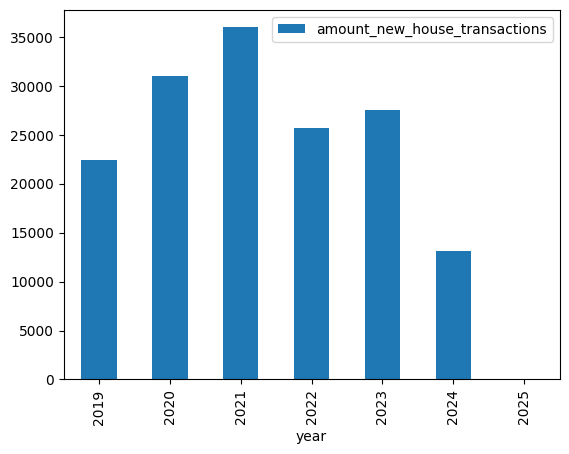

In [29]:
yearly_amount = master_df.groupby('year')[
'amount_new_house_transactions'].mean().reset_index()

# Create the bar chart
yearly_amount.plot.bar(x='year', y='amount_new_house_transactions');

In [30]:
monthly_amount = master_df.groupby('month')[
'amount_new_house_transactions'].mean().reset_index()

px.bar(monthly_amount, x = 'month', y = 'amount_new_house_transactions')

In [31]:
#master_df.insert(2, 'month_sin', np.sin(2 * np.pi * master_df['month']/12))

#master_df.insert(3, 'month_cos', np.cos(2 * np.pi * master_df['month']/12))

In [32]:
master_df.insert(2, 'is_december', (master_df['month'] == 12).astype(int))

master_df.insert(3, 'is_winter', master_df['month'].isin([12,1,]).astype(int))

In [33]:
master_df.insert(4, 'quarter', master_df['date'].dt.quarter)

master_df.insert(5, 'is_end_of_quarter', 
                 master_df['month'].isin([3,6,9,12]).astype(int))

# 3. Feature Engineering

In [34]:
target_col = 'amount_new_house_transactions'

lag_3_columns = ['num_new_house_transactions_nearby_sectors',
       'area_new_house_transactions_nearby_sectors',
       'amount_new_house_transactions_nearby_sectors',
 'area_new_house_transactions', 'num_land_transactions', 
           'construction_area','planned_building_area', 
           'transaction_amount'] 

lags = [1,3,6,9,12]

for col in lag_3_columns:
    for lag in lags:
        master_df[f"{col}_lag_{lag}"] = master_df.groupby(
            'sector')[col].shift(lag).fillna(0)

In [35]:
lag_4_columns = ['num_land_transactions','construction_area',
                 'planned_building_area','transaction_amount']

lags = [1,4,9,12]

for col in lag_4_columns:
    for lag in lags:
        master_df[f"{col}_lag_{lag}"] = master_df.groupby(
            'sector')[col].shift(lag).fillna(0)

In [36]:
windows = [3,4,6,9,12]

for col in lag_3_columns:
    for window in windows:
        master_df[f"{col}_roll_{window}"] = master_df.groupby(
            'sector')[col].transform(lambda x:x.rolling(window).mean()).fillna(0)

for col in lag_4_columns:
    for window in windows:
        master_df[f"{col}_roll_{window}"] = master_df.groupby(
            'sector')[col].transform(lambda x:x.rolling(window).mean()).fillna(0)

In [37]:
# Create encoder with unknown handling
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit and transform
result = encoder.fit_transform(master_df[['year']])

# Convert to DataFrame with readable column names
encoded_df = pd.DataFrame(result, columns=encoder.get_feature_names_out(
    ['year']), index=master_df.index) 

master_df = pd.concat([master_df,encoded_df], axis=1)

In [38]:
cut_off_date = pd.to_datetime('2024-07-01')

#DIVIDE TRAIN AND TEST DATA\

new_train = master_df[master_df['date'] <= cut_off_date]
new_test = master_df[master_df['date'] > cut_off_date]

In [39]:
new_train= new_train.reset_index(drop=True)
new_test= new_test.reset_index(drop=True)

# 4. Modelling

In [40]:
def custom_metric(y_test, y_pred):
    ## Step 1 - Check for "bad" samples (>100% error)
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    ape = np.abs((y_test - y_pred) / y_test)
    
    bad_samples = np.sum(ape > 1)     # errors > 100%
    good_samples = np.sum(ape <= 1)   # errors ≤ 100%
    total_samples = len(y_test)
    
    # If more than 30% are bad → score = 0
    if bad_samples / total_samples > 0.3:
        return 0.0
    
    ## Step 2 - Compute scaled MAPE for good samples only
    if good_samples == 0:  # avoid division by zero
        return 0.0
    
    mape_good = np.mean(ape[ape <= 1])
    
    # Scale MAPE by the fraction of good samples
    scaled_mape = mape_good / (good_samples / total_samples)
    
    # Score = 1 - scaled MAPE
    score = 1 - scaled_mape
    
    return score

In [41]:
train_df = new_train.copy()

In [42]:
#FEATURES
X_train = train_df.drop([target_col,'date','month','year',
             'sector','city_indicator_data_year',
                       'period_new_house_sell_through_nearby_sectors','id'],axis=1) 

X_test = new_test.drop([target_col,'date','month','year',
             'sector','city_indicator_data_year',
                       'period_new_house_sell_through_nearby_sectors','id'],axis=1) 

#TARGET
y_train = train_df[target_col]

In [43]:
# performing preprocessing part

sc = StandardScaler()

X_train_scaled = sc.fit_transform(X_train)

In [44]:
# Create a time series cross-validator with 3 splits
tscv = TimeSeriesSplit(n_splits=3)
score_list = []

In [45]:
for train_index, test_index in tscv.split(X_train):
    # Split data into train and test based on indices
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]
    
    # train model on past data (X_train, y_train)
    xg = XGBRegressor(learning_rate=0.1, 
                        max_depth=10, 
                        subsample=1,
                        reg_alpha= 0.5,
                        reg_lambda= 0.5,
                        min_child_weight =1,
                     n_estimators=500)

    xg.fit(X_train_fold,y_train_fold)
    
    # And evaluate it on future data (X_test, y_test)
    model = xg.predict(X_val_fold)

    #check model performance
    #score = custom_metric(y_val_fold,model)

    #append to list
    #score_list.append(score)

#average score
#avg_score = np.mean(score_list)
    
#print results
#print(f"MAPE : {avg_score : .3f}")

    # Compute absolute percentage errors (APE)
    ape = np.abs((y_val_fold - model) / y_val_fold)

    # Count "bad" samples (APE > 1 → more than 100% error)
    bad_samples = np.sum(ape > 1)

    # Proportion of bad samples
    proportion_bad = bad_samples / len(y_val_fold)

    print("Bad samples:", bad_samples)
    print("Proportion bad:", proportion_bad)

    # Check condition
    if proportion_bad > 0.3:
        print("⚠️ More than 30% are bad → score = 0")
    else:
        print("✅ Pass Stage 1, continue to Stage 2") 


Bad samples: 229
Proportion bad: 0.14393463230672532
✅ Pass Stage 1, continue to Stage 2
Bad samples: 228
Proportion bad: 0.1433060967944689
✅ Pass Stage 1, continue to Stage 2
Bad samples: 205
Proportion bad: 0.12884978001257072
✅ Pass Stage 1, continue to Stage 2


In [46]:
#model = LGBMRegressor()
#model.get_params()

In [47]:
for train_index, test_index in tscv.split(X_train):
    # Split data into train and test based on indices
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]
    
    # train model on past data (X_train, y_train)
    lgbm = LGBMRegressor(learning_rate=0.05)

    lgbm.fit(X_train_fold,y_train_fold)
    
    # And evaluate it on future data (X_test, y_test)
    model = lgbm.predict(X_val_fold)

    #check model performance
    score = custom_metric(y_val_fold,model)

    #append to list
    score_list.append(score)

#average score
avg_score = np.mean(score_list)
    
#print results
print(f"MAPE : {avg_score : .3f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23555
[LightGBM] [Info] Number of data points in the train set: 1592, number of used features: 312
[LightGBM] [Info] Start training from score 20211.162633
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 26493
[LightGBM] [Info] Number of data points in the train set: 3183, number of used features: 323
[LightGBM] [Info] Start training from score 28722.765028
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info

In [48]:
for train_index, test_index in tscv.split(X_train):
    # Split data into train and test based on indices
    X_train_fold, X_val_fold = X_train_scaled[train_index], X_train_scaled[test_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]
    
    # train model on past data (X_train, y_train)
    rf = RandomForestRegressor(
            #n_estimators = 200
                                )

    rf.fit(X_train_fold,y_train_fold)
    
    # And evaluate it on future data (X_test, y_test)
    model = rf.predict(X_val_fold)

    #check model performance
    score = custom_metric(y_val_fold,model)

    #append to list
    score_list.append(score)

#average score
avg_score = np.mean(score_list)
    
#print results
print(f"MAPE : {avg_score : .3f}")

MAPE :  0.908


# 6. Submission

In [49]:
#predictions = xg.predict(X_test)

In [50]:
#X_test_scaled = sc.transform(X_test)

In [51]:
# Predictions
pred_xgb = xg.predict(X_test)
pred_lgbm = lgbm.predict(X_test)
pred_rf = rf.predict(X_test)

# Weighted average (say 0.4, 0.4, 0.2)
final_predictions= 0.4 * pred_xgb + 0.4 * pred_lgbm + 0.2 * pred_rf 

In [52]:
new_test['new_house_transaction_amount'] = final_predictions

In [53]:
#new_test['id'] = new_test['date'].dt.strftime("%Y %b") + '_' + new_test['sector'] 

In [54]:
submission_df = new_test[['id','new_house_transaction_amount']]

In [55]:
submission_df = submission_df.reset_index(drop=True)

In [56]:
submission_df.to_csv('/kaggle/working/submission.csv', index=False)

In [57]:
!head submission.csv

id,new_house_transaction_amount
2024 Aug_sector 1,31689.002734102243
2024 Aug_sector 2,31689.002734102243
2024 Aug_sector 3,31658.29516982897
2024 Aug_sector 4,33297.31222052009
2024 Aug_sector 5,31658.29516982897
2024 Aug_sector 6,31689.002734102243
2024 Aug_sector 7,31689.002734102243
2024 Aug_sector 8,31689.002734102243
2024 Aug_sector 9,31689.002734102243
